In [124]:
from scipy.optimize import root
from numba import njit
import numpy as np
from scipy.linalg import eigvals


In [125]:
l = 1
beta0 = 0.5 #days^-1
gamma = 0.1 #days^-1
nu = 1/100 #days^-1
T_range = np.linspace(1,80, num = 200)
p_base_range = np.linspace(0.01, 0.35, num=200)


p_cap = 1e-3
epsilon = 1e-4
s = 0. # seasonal forcing
omega = 2 * np.pi / 360 #days⁻1

maxVax = 0.01 # Von N0 können pro tag geimpft werden

p_vax = 1000 # Zahl der Leute(*), die angst haben und sich deswegen Impfen lassen wollen
mu_im = 1/14 #1/days

In [126]:

@njit
def vax(H, params):
    p_base, T = params
    return (1- np.exp(-p_vax*H))* maxVax

def dVax(H, params):
    p_base, T = params
    return p_vax*np.exp(-p_vax * H)*maxVax

@njit
def P(H, params):
    p_base, T = params
    return p_base + (1-p_base)/p_cap * epsilon * np.log(1+np.exp(1/epsilon * (p_cap - H)))

@njit
def dP(H, params):
    p_base, T = params
    return (p_base-1)/p_cap*(np.exp(p_cap/epsilon))/(np.exp(H/epsilon)+np.exp(p_cap/epsilon))

In [141]:
@njit
def dS(S, V1, I, R, params):
    p_base, T = params
    return - beta0 * P(I, params) * I * S + nu * (R+mu_im/nu * V1) - vax(I, params) * S
@njit
def dV1(S, V1, I, R, params):
    p_base, T = params
    return +vax(I, params) * S - V1 * mu_im - beta0*P(I, params)*I*V1
@njit
def dI(S, V1, I, R, params):
    p_base, T = params
    return beta0 * P(I, params) * I * (S+V1) - gamma * I
@njit
def dR(S, V1, I, R, params):
    p_base, T = params
    return gamma*I-nu*R

@njit
def f(x, params):

    p_base, T = params
    (S, V1, I, R) = x
    return [dS(S, V1, I, R, params), dV1(S, V1, I, R, params), dI(S, V1, I, R, params), dR(S, V1, I, R, params)]

In [142]:
def jacRoot(x, params):

    p_base, T = params
    (S, V1, I, R) = x
    #misc
    #dPdH = (1-p_base)/p_cap*epsilon* (H-p_cap)*np.exp(p_cap/epsilon)/(epsilon**2*(np.exp(p_cap/epsilon)+np.exp(H/epsilon)))
    #dvaxdH = maxVax*H*np.exp(-p_cap*I
    

    V = mu_im/nu * V1
    
    dSdS = - beta0 * P(I, params)*I-vax(I, params)
    dSdV1 = mu_im
    dSdI = -beta0*P(I, params)*S - beta0 *I*S* dP(I, params) - S*dVax(I, params)
    dSdR = nu
    ######bis hier hin ok
    
    
    dV1dS =vax(I, params)
    dV1dV1 = -mu_im - beta0*P(I, params)*I
    dV1dI = + S * dVax(I, params) -beta0 * P(I, params)*V1  - beta0 * I * V1 * dP(I, params)
    dV1dR =0
    
    dIdS = beta0 * P(I, params) * I
    dIdV1 = beta0*P(I, params)*I
    dIdI = beta0*P(I, params)*(S+V1) + beta0*I*(S+V1)*dP(I, params) -gamma
    dIdR = 0.
    

    dRdS =0
    dRdV1 =0
    dRdI = gamma
    dRdR = -nu
    
    ret = np.array([
    [dSdS,dSdV1,dSdI,dSdR],
    [dV1dS,dV1dV1,dV1dI,dV1dR],
    [dIdS,dIdV1,dIdI,dIdR],
    [dRdS,dRdV1,dRdI,dRdR]])
    return ret

In [143]:
def jac(x, params): # x = S, V1, V, I, R, H1, H
    p_base, T = params
    (S, V1, V, I, R, H1, H) = x

    dSdS = -beta0 * P(H, params) * I - vax(H, params)
    dSdV1 = 0
    dSdV = nu
    dSdI = -beta0 * P(H, params) * S 
    dSdR = nu
    dSdH1 = 0
    dSdH = -beta0 * I *S * dP(H, params) - S * dVax(H, params)


    dV1dS = vax(H, params) 
    dV1dV1 = -mu_im - beta0 * P(H, params) * I
    dV1dV = 0
    dV1dI = -beta0 * P(H, params) * V1
    dV1dR = 0
    dV1dH1 = 0
    dV1dH = -beta0 * I * V1 * dP(H, params) + S * dVax(H, params)


    dVdS = 0
    dVdV1 = mu_im
    dVdV = -nu
    dVdI = 0
    dVdR = 0
    dVdH1 = 0
    dVdH = 0


    dIdS = beta0 * P(H, params) * I
    dIdV1 = beta0 * P(H, params) * I
    dIdV = 0
    dIdI = -gamma + beta0 * P(H, params) * (S + V1)
    dIdR = 0
    dIdH1 = 0
    dIdH = beta0 * I * (S+V1) * dP(H, params)


    dRdS = 0
    dRdV1 = 0
    dRdV = 0
    dRdI = gamma
    dRdR = -nu
    dRdH1 = 0
    dRdH = 0

    dH1dS = 0
    dH1dV1 = 0
    dH1dV = 0
    dH1dI = 2/T
    dH1dR = 0
    dH1dH1 = -2/T
    dH1dH = 0

    dHdS = 0
    dHdV1 = 0
    dHdV = 0
    dHdI = 0
    dHdR = 0
    dHdH1 = 2/T
    dHdH = -2/T

    ret = np.array([
        [dSdS ,dSdV1, dSdV ,dSdI ,dSdR ,dSdH1,dSdH],
        [dV1dS ,dV1dV1,dV1dV ,dV1dI ,dV1dR ,dV1dH1, dV1dH],
        [dVdS, dVdV1,dVdV ,dVdI ,dVdR ,dVdH1,dVdH],
        [dIdS, dIdV1,dIdV ,dIdI ,dIdR ,dIdH1,dIdH],
        [dRdS, dRdV1,dRdV ,dRdI ,dRdR ,dRdH1,dRdH],
        [dH1dS, dH1dV1, dH1dV, dH1dI, dH1dR, dH1dH1, dH1dH],
        [dHdS, dHdV1, dHdV, dHdI, dHdR ,dHdH1, dHdH ],
        
        ])
    return ret

In [144]:
def largestEW(jac):
    EW = eigvals(jac)
    return np.max(EW.real)

In [145]:
oldX = [0.55, 0.07, 0.001, 0.2]
sol = root(f, oldX, args = ((40, 0.1),))
sol

    fjac: array([[-7.95586902e-01,  5.56793871e-01,  2.38792938e-01,
        -1.04560796e-09],
       [-1.83598156e-01, -5.97199711e-01,  7.80797171e-01,
        -7.30623949e-09],
       [-2.88674703e-01, -2.88674658e-01, -2.88674917e-01,
         8.66025779e-01],
       [-5.00000115e-01, -5.00000033e-01, -5.00000502e-01,
        -4.99999350e-01]])
     fun: array([-1.58272091e-15,  2.66476484e-16,  1.31624442e-15, -6.73063421e-25])
 message: 'The solution converged.'
    nfev: 26
     qtf: array([ 3.16706875e-14,  2.14048663e-14, -4.99606156e-21, -9.00781554e-21])
       r: array([ 3.61979834e-03, -1.05686673e-01,  1.02661959e+01, -7.96044855e-03,
        1.56704244e-02, -1.29963645e+00, -1.84282234e-03,  1.15470006e-01,
       -1.15470062e-02, -1.01087139e-08])
  status: 1
 success: True
       x: array([7.15433782e-01, 5.07948451e-13, 5.10858242e-15, 5.10858243e-14])

In [150]:
karte = np.zeros((len(T_range), len(p_base_range)))-5
oldX = [0.55, 0.01, 0.001, 0.2]
for n,T in enumerate(T_range):
    for m,p in enumerate(p_base_range):
        sol = root(f, oldX, args = ((T, p),))
        x = sol.x
        # oldX = x
        S = x[0]
        V1 = x[1]
        V = mu_im/nu * V1
        I = x[2]
        R = x[3]
        H1 = I
        H = I
        fps = np.array([S, V1, V, I, R, H1, H]) # x = S, V1, V, I, R, H1, H
        
        if sol.success:
            karte[n,m] = largestEW(jac(fps, (T, p)))>0
        

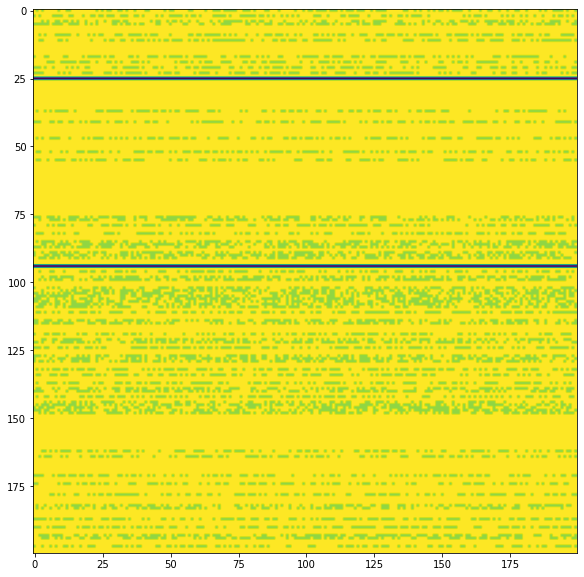

In [151]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(karte)